# Network Analysis and Mining
## HandsOn Session 8 Task 1
### Name: Aryan Kapoor
### SRN: PES2UG20CS069

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install --upgrade torch-cluster
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-cluster: filename=torch_cluster-1.6.1-cp39-cp39-linux_x86_64.whl size=744939 sha256=ce75945a288de4270efcf2082239b1d8a294d00bc51721ed7185a3f8c304d986
  Stored in directory: /root/.cache/pip/wheels/77/5a/b9/b61ba7d7a2e314173db70b38be991ddedc0225a4812bed2dc7
Successfully built torch-cluster
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [3]:
import networkx as nx
import random
import numpy as np
from typing import List
from tqdm import tqdm
from gensim.models.word2vec import Word2Vec
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import networkx as nx
import os.path as osp
import torch  
from tqdm.notebook import tqdm 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import Node2Vec
import torch_cluster
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# DeepWalk

In [11]:
class DeepWalk:
    def __init__(self, window_size: int, embedding_size: int, walk_length: int, walks_per_node: int):
        """
        :param window_size: window size for the Word2Vec model
        :param embedding_size: size of the final embedding
        :param walk_length: length of the walk
        :param walks_per_node: number of walks per node
        """
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.walk_length = walk_length
        self.walk_per_node = walks_per_node

    def random_walk(self, g: nx.Graph, start: str, use_probabilities: bool = False) -> List[str]:
        """
        Generate a random walk starting on start
        :param g: Graph
        :param start: starting node for the random walk
        :param use_probabilities: if True take into account the weights assigned to each edge to select the next candidate
        :return:
        """
        walk = [start]
        for i in range(self.walk_length):
            neighbours = g.neighbors(walk[i])
            neighs = list(neighbours)
            if use_probabilities:
                probabilities = [g.get_edge_data(walk[i], neig)["weight"] for neig in neighs]
                sum_probabilities = sum(probabilities)
                probabilities = list(map(lambda t: t / sum_probabilities, probabilities))
                p = np.random.choice(neighs, p=probabilities)
            else:
                p = random.choice(neighs)
            walk.append(p)
        return walk

    def get_walks(self, g: nx.Graph, use_probabilities: bool = False) -> List[List[str]]:
        """
        Generate all the random walks
        :param g: Graph
        :param use_probabilities:
        :return:
        """
        random_walks = []
        for _ in range(self.walk_per_node):
            random_nodes = list(g.nodes)
            random.shuffle(random_nodes)
            if len(random_nodes) > 0:
              for node in tqdm(random_nodes):
                  random_walks.append(self.random_walk(g=g, start=node, use_probabilities=use_probabilities))
        return random_walks

    def compute_embeddings(self, walks: List[List[str]]):
        """
        Compute the node embeddings for the generated walks
        :param walks: List of walks
        :return:
        """
        model = Word2Vec(sentences=walks, window=self.window_size, vector_size=self.embedding_size)
        return model.wv

dataset = TUDataset(root='data/TUDataset', name='PROTEINS')
g = dataset[0]
edge_list = g.edge_index.t().numpy()
g = nx.Graph()

for i in range(len(edge_list)):
  u = edge_list[i][0]
  v = edge_list[i][1]
  g.add_edge(u,v)

print(g.edges(data=True))

# Initialize the DeepWalk model
dw = DeepWalk(window_size=5, embedding_size=32, walk_length=10, walks_per_node=80)

# Generate the random walks
walks = dw.get_walks(g, use_probabilities=False)

# Compute the embeddings
embeddings = dw.compute_embeddings(walks)

# Retrieve the embedding of node 1
embedding_node_1 = embeddings.get_vector(1)
print(f"Embedding of node 1: {embedding_node_1}")


[(0, 11, {}), (0, 22, {}), (0, 32, {}), (11, 22, {}), (11, 32, {}), (22, 30, {}), (22, 40, {}), (32, 30, {}), (32, 40, {}), (1, 23, {}), (1, 31, {}), (1, 41, {}), (23, 24, {}), (23, 31, {}), (23, 34, {}), (23, 41, {}), (31, 12, {}), (31, 30, {}), (31, 33, {}), (31, 41, {}), (41, 12, {}), (41, 33, {}), (41, 40, {}), (2, 24, {}), (2, 29, {}), (2, 34, {}), (24, 33, {}), (29, 3, {}), (29, 4, {}), (34, 13, {}), (34, 33, {}), (3, 4, {}), (3, 28, {}), (3, 38, {}), (3, 39, {}), (4, 14, {}), (4, 28, {}), (4, 38, {}), (4, 39, {}), (28, 27, {}), (38, 15, {}), (38, 37, {}), (39, 13, {}), (39, 14, {}), (14, 13, {}), (14, 15, {}), (5, 6, {}), (5, 7, {}), (5, 26, {}), (6, 7, {}), (6, 8, {}), (7, 19, {}), (7, 25, {}), (26, 27, {}), (26, 37, {}), (8, 9, {}), (8, 10, {}), (8, 25, {}), (8, 35, {}), (19, 9, {}), (19, 16, {}), (19, 17, {}), (19, 18, {}), (19, 20, {}), (19, 21, {}), (19, 35, {}), (25, 9, {}), (9, 10, {}), (9, 21, {}), (9, 35, {}), (10, 20, {}), (35, 18, {}), (21, 20, {}), (12, 33, {}), (13,

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Embedding of node 1: [-0.99404466 -0.38531026  0.8335821   0.56001395 -0.465259   -0.1702311
  0.60965115  0.36943665  0.20025492 -0.34005994  0.5862047   0.45716295
  0.10078661 -0.11003003 -0.11365762 -0.42624545 -0.9117691   0.6417149
  0.667653    1.4557039   1.2273785  -0.05504929  0.887784   -0.07211345
  0.22613497  0.38128206 -0.10999957 -0.9300177   0.03152136 -0.032833
 -0.36168805  0.2903358 ]


In [12]:
for i in range(len(g.nodes())):
  embedding_node = embeddings.get_vector(i)
  print(f"Embedding node {i}: {embedding_node}")

Embedding node 0: [-0.23743     0.13705073  0.84549874  0.5815421   0.07296627  1.0863944
  0.8657489   0.31829566  0.63462085  0.31284615  1.1842209  -0.52863127
 -0.23761012 -0.19498296 -0.5392864  -0.09106017 -0.36487585 -0.86784226
  0.6134857   1.1128389   0.87176573  0.06688426  1.5651437   0.11487009
  0.08491276  0.6478547   0.3750659  -1.3212186  -0.03371695 -0.93813163
  0.415543    0.69921917]
Embedding node 1: [-0.99404466 -0.38531026  0.8335821   0.56001395 -0.465259   -0.1702311
  0.60965115  0.36943665  0.20025492 -0.34005994  0.5862047   0.45716295
  0.10078661 -0.11003003 -0.11365762 -0.42624545 -0.9117691   0.6417149
  0.667653    1.4557039   1.2273785  -0.05504929  0.887784   -0.07211345
  0.22613497  0.38128206 -0.10999957 -0.9300177   0.03152136 -0.032833
 -0.36168805  0.2903358 ]
Embedding node 2: [-1.2203213  -0.7252617   0.6965456  -0.07076123 -0.04169579 -0.8124129
  0.21461241  0.05394913 -0.16097887 -0.20053723 -0.12299272 -0.12886795
  0.008002    0.03158189

### Visualizing Embeddings


In [15]:
g.nodes()

NodeView((0, 11, 22, 32, 1, 23, 31, 41, 2, 24, 29, 34, 3, 4, 28, 38, 39, 14, 5, 6, 7, 26, 8, 19, 25, 9, 10, 35, 21, 20, 12, 33, 13, 15, 16, 17, 18, 36, 30, 40, 27, 37))

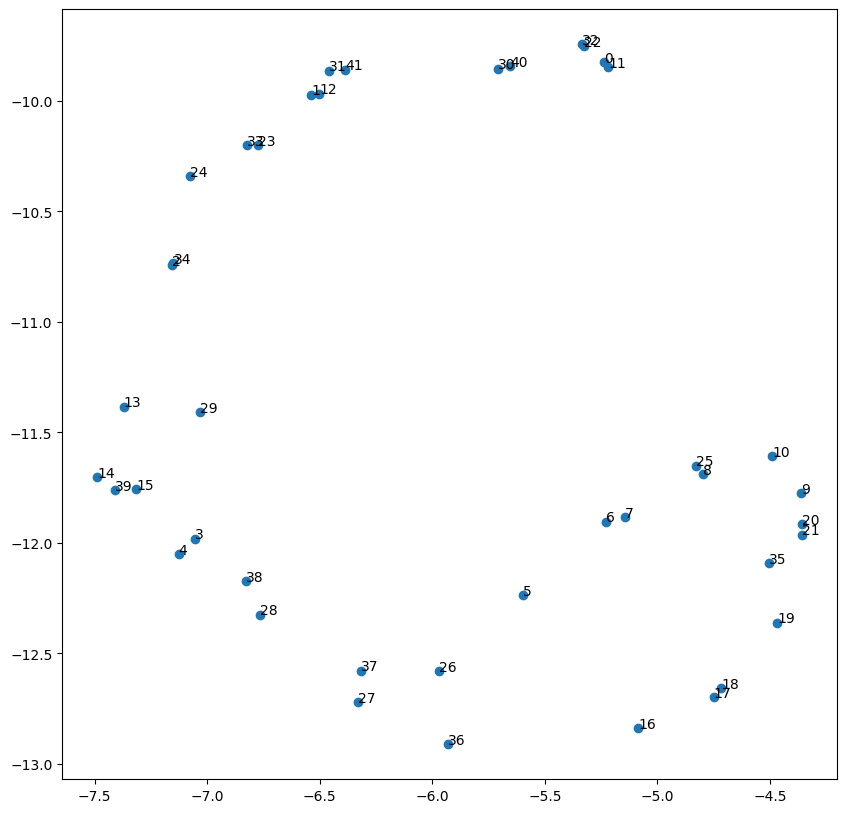

In [13]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform dimensionality reduction with t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings.vectors)

# Plot the embeddings
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for i, txt in enumerate(embeddings.index_to_key):
    ax.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()

# Node2Vec

### How the Dataset looks like

In [6]:
data = TUDataset(root='data/TUDataset', name='PROTEINS')
# data = TUDataset(".", name=dataset)

In [7]:
#Dataset information

print(data)
print("number of classes: ",data.num_classes,"\t\t(active),(inactive)")
print("number of features: ",data.num_features)
print("number of edge labels: ",data.num_edge_labels)

PROTEINS(1113)
number of classes:  2 		(active),(inactive)
number of features:  3
number of edge labels:  0


In [8]:
data_1 = data[10]

# extract the edge list
edge_list = data_1.edge_index.t().numpy()
print(edge_list[0:10])

[[ 0  1]
 [ 0 15]
 [ 0 16]
 [ 1  0]
 [ 1 15]
 [ 1 16]
 [ 1 17]
 [ 2  3]
 [ 2 14]
 [ 2 17]]


In [16]:
#Building the graph using NetworkX 
mol_graph = nx.Graph()

for i in range(len(edge_list)):
  u = edge_list[i][0]
  v = edge_list[i][1]
  mol_graph.add_edge(u,v)

print(mol_graph.edges(data=True))

[(0, 11, {}), (0, 22, {}), (0, 32, {}), (11, 22, {}), (11, 32, {}), (22, 30, {}), (22, 40, {}), (32, 30, {}), (32, 40, {}), (1, 23, {}), (1, 31, {}), (1, 41, {}), (23, 24, {}), (23, 31, {}), (23, 34, {}), (23, 41, {}), (31, 12, {}), (31, 30, {}), (31, 33, {}), (31, 41, {}), (41, 12, {}), (41, 33, {}), (41, 40, {}), (2, 24, {}), (2, 29, {}), (2, 34, {}), (24, 33, {}), (29, 3, {}), (29, 4, {}), (34, 13, {}), (34, 33, {}), (3, 4, {}), (3, 28, {}), (3, 38, {}), (3, 39, {}), (4, 14, {}), (4, 28, {}), (4, 38, {}), (4, 39, {}), (28, 27, {}), (38, 15, {}), (38, 37, {}), (39, 13, {}), (39, 14, {}), (14, 13, {}), (14, 15, {}), (5, 6, {}), (5, 7, {}), (5, 26, {}), (6, 7, {}), (6, 8, {}), (7, 19, {}), (7, 25, {}), (26, 27, {}), (26, 37, {}), (8, 9, {}), (8, 10, {}), (8, 25, {}), (8, 35, {}), (19, 9, {}), (19, 16, {}), (19, 17, {}), (19, 18, {}), (19, 20, {}), (19, 21, {}), (19, 35, {}), (25, 9, {}), (9, 10, {}), (9, 21, {}), (9, 35, {}), (10, 20, {}), (35, 18, {}), (21, 20, {}), (12, 33, {}), (13,

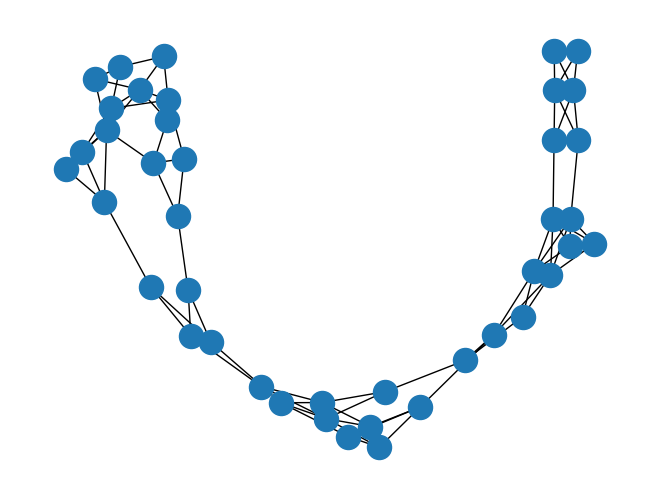

In [17]:
#Visualise the graph of the molecule
pos = nx.spring_layout(mol_graph)
nx.draw(mol_graph,pos)
nx.draw_networkx_edge_labels(mol_graph,pos,nx.get_edge_attributes(mol_graph,'label'))
plt.show()

In [18]:
data = data[10]
data

Data(edge_index=[2, 64], x=[20, 3], y=[1])

### Building the train,test and val mask of the graphs

In [19]:
np.random.seed(10)
#get the nodes
nodes = data.edge_index.t().numpy()
nodes = np.unique(list(nodes[:,0]) + list(nodes[:,1]))

#shuffle node order
np.random.shuffle(nodes) 
print(len(nodes))

20


In [20]:
#get train test and val sizes: (70% - 15% - 15%)
train_size = int(len(nodes)*0.7)
test_size = int(len(nodes)*0.85) - train_size
val_size = len(nodes) - train_size - test_size

In [21]:
#get train test and validation set of nodes
train_set = nodes[0:train_size]
test_set = nodes[train_size:train_size+test_size]
val_set = nodes[train_size+test_size:]


print(len(train_set),len(test_set),len(val_set))
print(len(train_set)+len(test_set)+len(val_set) == len(nodes))

print("train set\t",train_set[:10])
print("test set \t",test_set[:10])
print("val set  \t",val_set[:10])

14 3 3
True
train set	 [ 7 10  5  6  3 18 13  2 14  8]
test set 	 [11  1  0]
val set  	 [15  4  9]


In [22]:
#build test train val masks
train_mask = torch.zeros(len(nodes),dtype=torch.long)
for i in train_set:
    train_mask[i] = 1.

test_mask = torch.zeros(len(nodes),dtype=torch.long)
for i in test_set:
    test_mask[i] = 1.
    
val_mask = torch.zeros(len(nodes),dtype=torch.long)
for i in val_set:
    val_mask[i] = 1.
    
print("train mask \t",train_mask[0:15])
print("test mask  \t",test_mask[0:15])
print("val mask   \t",val_mask[0:15]) 

train mask 	 tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1])
test mask  	 tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
val mask   	 tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


In [23]:
#removing unnecessary data 
print("before\t",data)
data.x = None
data.edge_attr = None
data.y = None

before	 Data(edge_index=[2, 64], x=[20, 3], y=[1])


In [24]:
#add masks 
data.train_mask = train_mask 
data.test_mask = test_mask 
data.val_mask = val_mask 

print("after\t",data)

after	 Data(edge_index=[2, 64], train_mask=[20], test_mask=[20], val_mask=[20])


### Defining the model for Node Embeddings


In [25]:
#Setting the device (cuda gpu or cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Defining the model - setting walk length, walks per node, values of p and q in the negative sampling
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True) #context soze -> no. of neighbours to condsider fro a particular node; 
             #Num_negative_samples -> no. of negative random walks per positive radom walk

#Defining loader and optimiser 
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
"""CONTEXT FOR NEXT CELL ->In a neural network, "forward" and "backward" refer to the two main stages of the computation: forward propagation and backward propagation (also known as backpropagation).

Forward propagation is the process of computing the output of the neural network given its input. 
In this stage, the input data is fed into the network, and the network performs a series of computations (e.g., matrix multiplications, non-linear activations, etc.) to produce an output. 
The output is then compared to the target value, and the resulting error is used to update the network parameters during the backward propagation stage.

Backward propagation is the process of computing the gradients of the loss function with respect to the parameters of the neural network. 
In this stage, the error from the output stage is propagated backward through the network using the chain rule of calculus to compute the gradients of the loss function with respect to the parameters of the network. 
These gradients are then used to update the parameters of the network using an optimization algorithm such as stochastic gradient descent (SGD)."""

'CONTEXT FOR NEXT CELL ->In a neural network, "forward" and "backward" refer to the two main stages of the computation: forward propagation and backward propagation (also known as backpropagation).\n\nForward propagation is the process of computing the output of the neural network given its input. \nIn this stage, the input data is fed into the network, and the network performs a series of computations (e.g., matrix multiplications, non-linear activations, etc.) to produce an output. \nThe output is then compared to the target value, and the resulting error is used to update the network parameters during the backward propagation stage.\n\nBackward propagation is the process of computing the gradients of the loss function with respect to the parameters of the neural network. \nIn this stage, the error from the output stage is propagated backward through the network using the chain rule of calculus to compute the gradients of the loss function with respect to the parameters of the networ

In [27]:
#Training function 
def train():
  model.train()
  total_loss = 0 
  for pos_rw,neg_rw in loader: #positive random walk, negative random walk
    optimizer.zero_grad() #set gradients to zero 
    loss = model.loss(pos_rw.to(device), neg_rw.to(device)) #calculating loss of positive and negative random walks
    loss.backward() #compute gradients through backward propogation
    optimizer.step() #updating model parameters
    total_loss += loss.item()
  return total_loss / len(loader)

In [28]:
#Testing function 
@torch.no_grad() #to disable gradient computation
def test():
    model.eval() #setting model to evaluation
    z = model() #compute embeddings for all nodes
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10) 
    #The test method trains a logistic regression classifier on the training data using the node embeddings as features, and evaluates the classifier's accuracy on the test data.
    return acc

In [30]:
#Model execution
z = model()

### Visualizing the Node embeddings

In [31]:
#convert from tensor to numpy array 
emb_128 = z.detach().cpu().numpy()

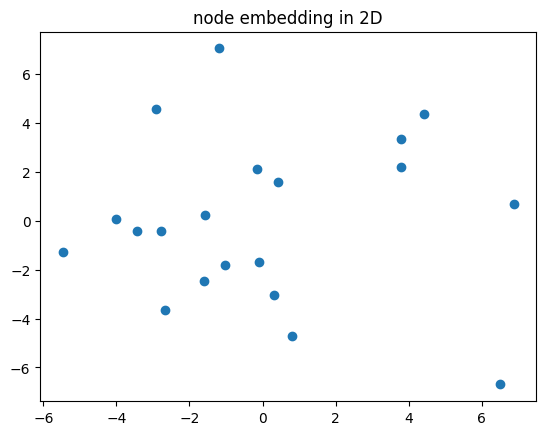

In [32]:
#fit and transform using PCA
pca = PCA(n_components=2) #2 PCs from 128 dimensions
emb2d = pca.fit_transform(emb_128)


plt.title("node embedding in 2D")
plt.scatter(emb2d[:,0],emb2d[:,1])
plt.show()

# Network Analysis and Mining
## HandsOn Session 8 Task 2
### Name: Aryan Kapoor
### SRN: PES2UG20CS069

In [40]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from sklearn.model_selection import train_test_split

In [42]:
# Load dataset
dataset = Planetoid(root='data/Planetoid/Cora', name='Cora')
data = dataset[0]
x_train, x_test, y_train, y_test = train_test_split(data.x, data.y, test_size=0.2, random_state=42)
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:len(y_train)] = True
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[len(y_train):] = True
data.train_mask = train_mask
data.test_mask = test_mask

Processing...
Done!


# GCN

In [43]:
# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        #x = F.dropout(x, training=self.training)
       # x = F.relu(self.conv3(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

In [44]:
model = GCN(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [45]:
# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    print(f"loss:{loss}, epoch:{epoch}")
    loss.backward()
    optimizer.step()

loss:1.9500612020492554, epoch:0
loss:1.8834326267242432, epoch:1
loss:1.811787724494934, epoch:2
loss:1.7534191608428955, epoch:3
loss:1.6899874210357666, epoch:4
loss:1.6605374813079834, epoch:5
loss:1.5786651372909546, epoch:6
loss:1.5162990093231201, epoch:7
loss:1.4530102014541626, epoch:8
loss:1.4009510278701782, epoch:9
loss:1.3342853784561157, epoch:10
loss:1.2850632667541504, epoch:11
loss:1.2543872594833374, epoch:12
loss:1.1731584072113037, epoch:13
loss:1.1268982887268066, epoch:14
loss:1.0948922634124756, epoch:15
loss:1.0801640748977661, epoch:16
loss:1.0121039152145386, epoch:17
loss:0.9786064624786377, epoch:18
loss:0.9228375554084778, epoch:19
loss:0.8927781581878662, epoch:20
loss:0.856358528137207, epoch:21
loss:0.8447610139846802, epoch:22
loss:0.7818447351455688, epoch:23
loss:0.7620869874954224, epoch:24
loss:0.7229502201080322, epoch:25
loss:0.7601507902145386, epoch:26
loss:0.7185359001159668, epoch:27
loss:0.6940492987632751, epoch:28
loss:0.6421108841896057, e

In [46]:
# Evaluate the model
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'GCN Train Accuracy: {train_acc:.4f}')
print(f'GCN Test Accuracy: {test_acc:.4f}')

GCN Train Accuracy: 0.9483
GCN Test Accuracy: 0.8911


# GAT

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, in_channels, out_channels, heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, out_channels, heads=heads)
        self.conv2 = GATConv(out_channels*heads, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
     


In [48]:
model = GAT(data.num_features, 8,2)
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

In [49]:
# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    print(f"loss:{loss}, epoch:{epoch}")
    loss.backward()
    optimizer.step()

loss:1.948822259902954, epoch:0
loss:1.866786003112793, epoch:1
loss:1.7756116390228271, epoch:2
loss:1.7141648530960083, epoch:3
loss:1.6418828964233398, epoch:4
loss:1.5861763954162598, epoch:5
loss:1.5240625143051147, epoch:6
loss:1.4669030904769897, epoch:7
loss:1.442138910293579, epoch:8
loss:1.3587076663970947, epoch:9
loss:1.2989206314086914, epoch:10
loss:1.2587004899978638, epoch:11
loss:1.1734087467193604, epoch:12
loss:1.1613349914550781, epoch:13
loss:1.0787136554718018, epoch:14
loss:1.0692886114120483, epoch:15
loss:1.0298832654953003, epoch:16
loss:0.9744539260864258, epoch:17
loss:0.9493491649627686, epoch:18
loss:0.9205936193466187, epoch:19
loss:0.8855425119400024, epoch:20
loss:0.8411433100700378, epoch:21
loss:0.8432425260543823, epoch:22
loss:0.7856326103210449, epoch:23
loss:0.7583848237991333, epoch:24
loss:0.7421724200248718, epoch:25
loss:0.7690247297286987, epoch:26
loss:0.7351740002632141, epoch:27
loss:0.7370938658714294, epoch:28
loss:0.7065654397010803, ep

In [50]:
# Evaluate the model
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'GAT Train Accuracy: {train_acc:.4f}')
print(f'GAT Test Accuracy: {test_acc:.4f}')

GAT Train Accuracy: 0.9548
GAT Test Accuracy: 0.8911


# GraphSage

In [51]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [52]:
model = GraphSAGE(data.num_features, 16, dataset.num_classes)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [53]:
# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    print(f"loss:{loss}, epoch:{epoch}")
    loss.backward()
    optimizer.step()

loss:1.9744220972061157, epoch:0
loss:1.8459103107452393, epoch:1
loss:1.7040190696716309, epoch:2
loss:1.5548863410949707, epoch:3
loss:1.4327051639556885, epoch:4
loss:1.2872190475463867, epoch:5
loss:1.1639543771743774, epoch:6
loss:1.0630285739898682, epoch:7
loss:0.9656023383140564, epoch:8
loss:0.8691619038581848, epoch:9
loss:0.79140704870224, epoch:10
loss:0.7290940284729004, epoch:11
loss:0.6662064790725708, epoch:12
loss:0.6203065514564514, epoch:13
loss:0.586329460144043, epoch:14
loss:0.5344334244728088, epoch:15
loss:0.5045856237411499, epoch:16
loss:0.4659932255744934, epoch:17
loss:0.45698902010917664, epoch:18
loss:0.44722050428390503, epoch:19
loss:0.4188736379146576, epoch:20
loss:0.38916435837745667, epoch:21
loss:0.376183420419693, epoch:22
loss:0.3788336515426636, epoch:23
loss:0.3928702473640442, epoch:24
loss:0.36260855197906494, epoch:25
loss:0.34369924664497375, epoch:26
loss:0.3292863965034485, epoch:27
loss:0.34926652908325195, epoch:28
loss:0.334875524044036

In [54]:
# Evaluate the model
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
train_acc = pred[data.train_mask].eq(data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
test_acc = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'GraphSage Train Accuracy: {train_acc:.4f}')
print(f'GraphSage Test Accuracy: {test_acc:.4f}')

GraphSage Train Accuracy: 0.9986
GraphSage Test Accuracy: 0.8782
